In [1]:
#Save "SageMaker Prediction.py" as inference.py in the same folder as this notebook. inference.py is a mandatory name and can not be changed

In [2]:
%time
models_data = ['s3://sagemaker-wc-class/model/fold_0/basemodel0-class-XGB-0-2020-10-29-22-41-41/output/model.tar.gz', 
             's3://sagemaker-wc-class/model/fold_1/basemodel0-class-XGB-1-2020-10-29-22-41-54/output/model.tar.gz', 
             's3://sagemaker-wc-class/model/fold_2/basemodel0-class-XGB-2-2020-10-29-22-42-07/output/model.tar.gz', 
             's3://sagemaker-wc-class/model/fold_3/basemodel0-class-XGB-3-2020-10-29-22-42-19/output/model.tar.gz', 
             's3://sagemaker-wc-class/model/fold_4/basemodel0-class-XGB-4-2020-10-29-22-42-31/output/model.tar.gz']
#where to store partial dependency file
ModelsDir = '/home/kate/Research/Property/Models/'
#where are training data located locally
DataDir = '/home/kate/Research/Property/Data/'
#Temp local dir to save file before moving to S3
TmpDir = '/home/kate/Research/Property/Notebooks/SageMaker/tmp/'
#dataset file name with features to predict
dataset_name='property_wcf_class_training_basemodel0'
#model featureset
featureset  = [
'roofcd_encd',
'sqft',  
'usagetype_encd',
'yearbuilt',
'water_risk_3_blk',
'landlordind',
'multipolicyind'  
]
#column names for predicted values
continuous_features=['yearbuilt','sqft','water_risk_3_blk']
#instance type to be created for transformation jobs. 
instance_type='ml.c5.xlarge'
#Transformation jobs
#Model is created for each fold model_name is just a template. fold number will be added 
transformation_job_entry_point='inference.py'
#timeout for waiting Shap Values
transformation_job_timeout = 3600
transformation_input_folder = 'input'
transformation_output_folder = 'output'
model_name='property-wcf-class-basemodel0'
#S3 bucket and folders to save files
bucket = 'sagemaker-wc-class'
s3_batch_output = 's3://%s/%s/%s_fold_'%(bucket,transformation_output_folder,model_name)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.34 µs


In [3]:
%%time
#packages used in the notebook
import time
import sys
import boto3
import re
import sagemaker
from sagemaker.session import s3_input
from sagemaker.xgboost.model import XGBoostModel
import pandas as pd
import numpy as np
import s3fs

CPU times: user 472 ms, sys: 39.5 ms, total: 511 ms
Wall time: 510 ms


In [4]:
%%time
#should be run as a first step
#role arn is used when run from a local machine
role = 'arn:aws:iam::'
region = boto3.Session().region_name
s3 = s3fs.S3FileSystem()
smclient = boto3.Session().client('sagemaker')

CPU times: user 68.6 ms, sys: 4.06 ms, total: 72.6 ms
Wall time: 71.8 ms


In [5]:
%%time
#data
dataset = pd.read_csv('%s%s.csv'%(DataDir,dataset_name), error_bad_lines=False, index_col=False)

CPU times: user 558 ms, sys: 51.4 ms, total: 610 ms
Wall time: 609 ms


In [7]:
%time
#takes 37 min to load
#creating dataset with all possible combination unique values of one feature and all others
#the result is a huge dataset we need to predict
features_datasets = list()
for f in featureset:
    print('Processing %s'%f)
    dataset_feature = pd.DataFrame()
    dataset_temp = dataset[featureset].copy()
    if f in continuous_features:
        # continuous
        grid = sorted(np.linspace(np.percentile(dataset_temp[f], 0.1),
                       np.percentile(dataset_temp[f], 99.5),
                          50))
    else:
        #categorical
        grid = sorted(dataset_temp[f].unique())
        
    for i, val in enumerate(grid):
        dataset_temp[f] = val
        dataset_feature=dataset_feature.append(dataset_temp)
    features_datasets.append(dataset_feature)    
    #Load data to S3 bucket
    s3_batch_input = 's3://%s/%s/%s_%s.csv'%(bucket,transformation_input_folder,dataset_name,f)
    if not(s3.exists(s3_batch_input)):
        print('%s_%s.csv does not exist in S3. Loading...'%(dataset_name,f))
        dataset_feature.to_csv(s3_batch_input,header=False,index=False)
    else:
        print('%s_%s.csv exists in S3'%(dataset_name,f))

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.58 µs
Processing roofcd_encd
property_wcf_class_training_basemodel0_roofcd_encd.csv does not exist in S3. Loading...
Processing sqft
property_wcf_class_training_basemodel0_sqft.csv does not exist in S3. Loading...
Processing usagetype_encd
property_wcf_class_training_basemodel0_usagetype_encd.csv does not exist in S3. Loading...
Processing yearbuilt
property_wcf_class_training_basemodel0_yearbuilt.csv does not exist in S3. Loading...
Processing water_risk_3_blk
property_wcf_class_training_basemodel0_water_risk_3_blk.csv does not exist in S3. Loading...
Processing landlordind
property_wcf_class_training_basemodel0_landlordind.csv does not exist in S3. Loading...
Processing multipolicyind
property_wcf_class_training_basemodel0_multipolicyind.csv does not exist in S3. Loading...


In [10]:
# 42,115,080 with cont spec
# 259,709,660 full

In [11]:
%%time
#Models to be used in prediction
#based on model files provided in models_data
models = list()
i = 0
for m in models_data:    
    #Try to delete if exists model and create a new model based on a model file
    name=model_name+'-%s'%i
    try:
        response = smclient.delete_model(ModelName=name)
        print('%s model was deleted'%name)
    except:
        print('%s model does not exist'%name)
        pass
    xgb_inference_model = XGBoostModel(
    name=name,
    model_data=m,
    role=role,
    entry_point=transformation_job_entry_point,
    framework_version="1.0-1",
    )
    models.append(xgb_inference_model)
    print('%s model was created'%name)
    i = i + 1        

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


property-wcf-class-basemodel0-0 model was deleted
property-wcf-class-basemodel0-0 model was created


Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


property-wcf-class-basemodel0-1 model was deleted
property-wcf-class-basemodel0-1 model was created


Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


property-wcf-class-basemodel0-2 model was deleted
property-wcf-class-basemodel0-2 model was created


Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


property-wcf-class-basemodel0-3 model was deleted
property-wcf-class-basemodel0-3 model was created


Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


property-wcf-class-basemodel0-4 model was deleted
property-wcf-class-basemodel0-4 model was created
CPU times: user 205 ms, sys: 20.8 ms, total: 226 ms
Wall time: 7.1 s


In [12]:
s3_batch_input = 's3://%s/%s/'%(bucket,transformation_input_folder)

In [13]:
%time
tranform_jobs = list()
tranformers = list()
i = 0
for m in models:       
#Create transform job
    s3_batch_output_fold=s3_batch_output+'%s'%i
    transformer =  m.transformer(
                                              instance_count=1, 
                                              instance_type=instance_type,
                                              output_path=s3_batch_output_fold,
                                              accept='text/csv',
                                              strategy='MultiRecord',
                                              assemble_with='Line'
                                             ,env = {'SAGEMAKER_MODEL_SERVER_TIMEOUT' : str(transformation_job_timeout) }
                                             )
    tranformers.append(transformer)
    transformer.transform(data=s3_batch_input, content_type='text/csv',split_type='Line')
    job_name = transformer.latest_transform_job.name
    tranform_jobs.append(job_name)
    print('Job %s started'%job_name)
    i = i + 1

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.68 µs
Job property-wcf-class-basemodel0-0-2020-11-02-04-52-19-983 started
Job property-wcf-class-basemodel0-1-2020-11-02-04-52-21-539 started
Job property-wcf-class-basemodel0-2-2020-11-02-04-52-23-657 started
Job property-wcf-class-basemodel0-3-2020-11-02-04-52-25-218 started
Job property-wcf-class-basemodel0-4-2020-11-02-04-52-27-012 started


In [14]:
%time
#If there are not complete training jobs in 5-6 minutes, it's better to look into logs. Took 20 min 1 job for ~42M rows
check_every_sec=60
print_every_n_output=6
t = 0
n = 0
minutes_to_wait=60*60/check_every_sec
while True:
    statuses = list()
    n = n + 1
    for e,j in zip(tranformers,tranform_jobs):
        status=e.sagemaker_session.describe_transform_job(j)['TransformJobStatus']
        if n==print_every_n_output:
            print('Transform job %s status: %s'%(j,status))
        statuses.append(status)
    if 'InProgress' in statuses:
        if n==print_every_n_output:
            print('Continue waiting...')
            n = 0
    else:
        if set(statuses)=={'Completed'}:
            print('All Transform Jobs are Completed')
        else:
            print('Something went wrong.')
        break 
    t = t+1
    if t>minutes_to_wait:
        print('Something went wrong. Transform jobs are still running.')
        break
    time.sleep(check_every_sec)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs
Transform job property-wcf-class-basemodel0-0-2020-11-02-04-52-19-983 status: InProgress
Transform job property-wcf-class-basemodel0-1-2020-11-02-04-52-21-539 status: InProgress
Transform job property-wcf-class-basemodel0-2-2020-11-02-04-52-23-657 status: InProgress
Transform job property-wcf-class-basemodel0-3-2020-11-02-04-52-25-218 status: InProgress
Transform job property-wcf-class-basemodel0-4-2020-11-02-04-52-27-012 status: InProgress
Continue waiting...
Transform job property-wcf-class-basemodel0-0-2020-11-02-04-52-19-983 status: InProgress
Transform job property-wcf-class-basemodel0-1-2020-11-02-04-52-21-539 status: InProgress
Transform job property-wcf-class-basemodel0-2-2020-11-02-04-52-23-657 status: InProgress
Transform job property-wcf-class-basemodel0-3-2020-11-02-04-52-25-218 status: InProgress
Transform job property-wcf-class-basemodel0-4-2020-11-02-04-52-27-012 status: InProgress
Continue waiting...
Tr

In [15]:
%time
#reading data from S3 and joining with values
i = 0
kfold=len(models)
for m in models:   
    print('Reading predicted data fold: {}  of  {} : '.format(i+1, kfold))
    j = 0
    for f in featureset:
        print('Processing %s'%f)
        s3_batch_output_feature_fold = s3_batch_output + '%s/%s_%s.csv.out'%(i,dataset_name,f)
        if s3.exists(s3_batch_output_feature_fold):
            pdf_dataset = pd.read_csv(s3_batch_output_feature_fold, names=['pd'], error_bad_lines=False, index_col=False) 
        else:
            print(s3_batch_output_feature_fold+' does not exists')       
        features_datasets[j]['pd_fold_%s'%i]= pdf_dataset['pd'].values
        j = j + 1
    i = i + 1

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs
Reading predicted data fold: 1  of  5 : 
Processing roofcd_encd
Processing sqft
Processing usagetype_encd
Processing yearbuilt
Processing water_risk_3_blk
Processing landlordind
Processing multipolicyind
Reading predicted data fold: 2  of  5 : 
Processing roofcd_encd
Processing sqft
Processing usagetype_encd
Processing yearbuilt
Processing water_risk_3_blk
Processing landlordind
Processing multipolicyind
Reading predicted data fold: 3  of  5 : 
Processing roofcd_encd
Processing sqft
Processing usagetype_encd
Processing yearbuilt
Processing water_risk_3_blk
Processing landlordind
Processing multipolicyind
Reading predicted data fold: 4  of  5 : 
Processing roofcd_encd
Processing sqft
Processing usagetype_encd
Processing yearbuilt
Processing water_risk_3_blk
Processing landlordind
Processing multipolicyind
Reading predicted data fold: 5  of  5 : 
Processing roofcd_encd
Processing sqft
Processing usagetype_encd
Processing year

In [16]:
%time
#averaging results
all_fm_pd = pd.DataFrame()
i = 0
for m in models:
    j = 0
    for f in featureset:
        fm_s = features_datasets[j].groupby(f)['pd_fold_%s'%i].mean()
        fm_pd=pd.DataFrame({'value':fm_s.index, 'pd':fm_s.values})
        fm_pd['feature']=f
        fm_pd['fold']=i
        fm_pd['ModelName']=model_name
        fm_pd = fm_pd[['ModelName','fold','feature','value','pd']]
        all_fm_pd=all_fm_pd.append(fm_pd)
        j = j + 1
    i = i + 1

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.11 µs


In [19]:
#Save To file
all_fm_pd.to_csv('%sSageMaker_%s_PartialDependency.csv'%(ModelsDir,model_name),header=True,index=False)

In [20]:
#Visualization
%matplotlib inline

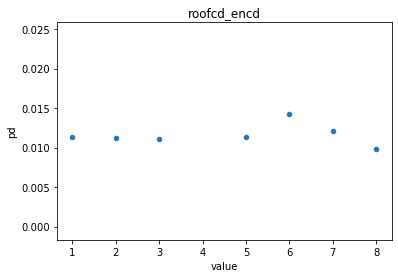

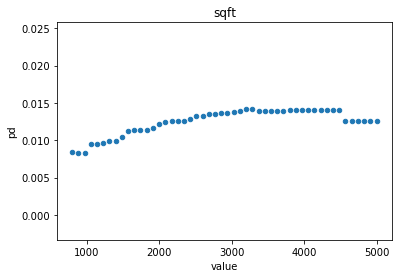

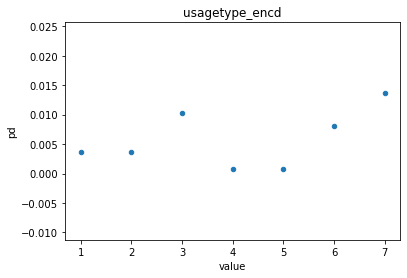

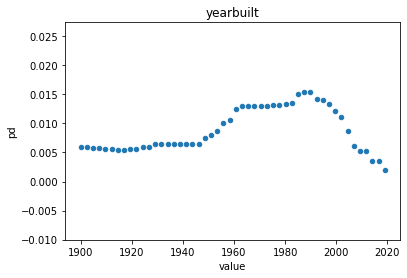

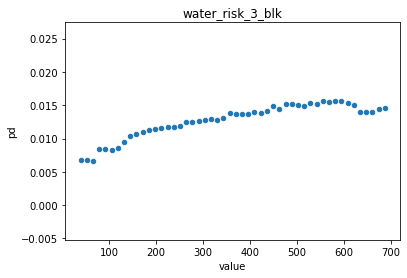

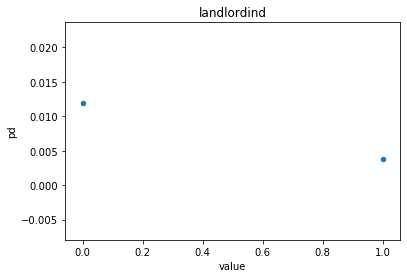

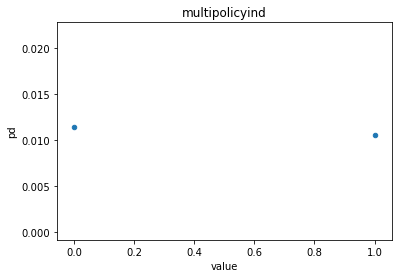

In [21]:
#averaging by fold
pd = all_fm_pd.groupby(['ModelName','feature','value'])['pd'].mean().to_frame(name='pd')
pd.reset_index(inplace=True)
for f in featureset:
    pd[pd['feature']==f].plot(kind='scatter',x='value', y='pd', title=f)